In [382]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [383]:
class HeatEquation:
    
    def __init__(self, u_0, g_0, g_1, f):
        self.u_0 = u_0
        self.g_0 = g_0
        self.g_1 = g_1
        self.f = f
        
    
    def solve_equation(self, Nx, Nt, teta):
        u = np.zeros((Nt,Nx))
        x = self.__split(Nx)
        t = self.__split(Nt)
        f_values = self.__compute_two_arg_function_values(self.f, t, x)
        u[0] = np.array(self.u_0(x))
        u[:,0] = np.array(self.g_0(t))
        u[:,Nx-1] = np.array(self.g_1(t))
        tau = 1/(Nt-1)
        # Для вычисления u на слое 1 восопльзуемся простой неявной схемой
        u[1] = self.__compute_u_1(u, f_values, tau)
        for n in range (2, Nt):
            A, b = self.__create_matrix(Nx, u, f_values, n, tau, teta)
            u[n] = self.__solve_linear_system(A,b)
        return u
    
    def __compute_u_1(self, u, f_values, tau):
        Nx = len(u[0])
        h=1/(Nx-1)
        A = np.zeros((Nx,Nx))
        b = np.zeros(Nx)
        A[0,0] = 1
        A[Nx-1, Nx-1] = 1
        b[0] = u[1,0]
        b[Nx-1] = u[1,Nx-1]
        for j in range(1,Nx-1):
            A[j,j+1] = -1/h**2
            A[j,j] = 1/tau + 2/h**2
            A[j,j-1] = -1/h**2
            b[j] = 1/tau * u[0,j] + f_values[1,j]
        return self.__solve_linear_system(A,b)
            
        
        
    def __create_matrix(self, Nx, u, f_values, n, tau, teta):
        h=1/(Nx-1)
        A = np.zeros((Nx,Nx))
        b = np.zeros(Nx)
        A[0,0] = 1
        A[Nx-1, Nx-1] = 1
        b[0] = u[n,0]
        b[Nx-1] = u[n,Nx-1]
        for j in range(1,Nx-1):
            A[j,j+1] = -1/h**2
            A[j,j] = 2/h**2 + (1+teta)/tau
            A[j,j-1] = -1/h**2
            b[j] = (1+2*teta)/tau * u[n-1,j] - teta/tau * u[n-2,j] + f_values[n,j]
        return A, b
        
    def __compute_one_arg_function_values(self, function, args):
        values = np.zeros(len(args))
        for i in range (len(args)):
            values[i] = function(args[i])
        return values
    
    def __compute_two_arg_function_values(self, function, args1, args2):
        values = np.zeros((len(args1), len(args2)))
        for i in range (len(args1)):
            for j in range (len(args2)):
                values[i,j] = function(args1[i],args2[j])
        return values
        
    def __split(self, N):
        h = 1/(N-1)
        points = np.zeros(N)
        for i in range (N):
            points[i] = i * h
        return points
    
    
    def __solve_linear_system(self,A,b):
        n = len(b)
        alpha = np.zeros(n-1)
        beta = np.zeros(n-1)
        beta[0] = b[0]
        for i in range(1,n-1):
            alpha[i] = -A[i,i+1]/(A[i,i-1]*alpha[i-1]+A[i,i])
            beta[i] = (b[i] - A[i,i-1]*beta[i-1])/(A[i,i-1]*alpha[i-1] + A[i,i])
        y = np.zeros(n)

        y[n-1] = b[n-1]
        for i in range(n-2, -1,-1):
            y[i] = y[i+1] * alpha[i] + beta[i]
        return y

In [384]:
def compute_error_norm_1d(u1,u2):
    errors = np.zeros(len(u1))
    for i in range (len(u1)):
        errors[i] = np.abs(u1[i] - u2[i])
    return np.max(errors)

def compute_error_norm_2d(u1,u2):
    errors = []
    for i in range (len(u1)):
        for j in range(len(u1[i])):
            errors.append(np.abs(u1[i,j] - u2[i,j]))
    return np.max(errors)

error norm = 1.634732127442362e-09


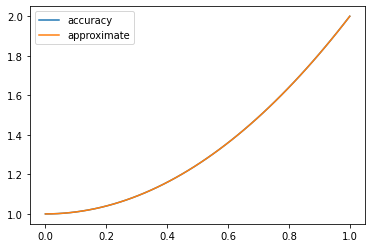

In [385]:
Nx = 50
Nt = 250
x = np.zeros(Nx)
for i in range (Nx):
    x[i] = i/(Nx-1)
t = np.zeros(Nt)
for i in range (Nt):
    t[i] = i/(Nt-1)

eq = HeatEquation(lambda x: x**2, lambda t:t**2, lambda t: t**2 + 1, lambda t,x: 2*t-2)
u_h = eq.solve_equation(Nx,Nt,1/2)

u = lambda t,x: x**2+t**2
u_ac = np.zeros((Nt,Nx)) 
for i in range (Nt):
    for j in range (Nx):
        u_ac[i,j] = u(t[i],x[j])
        
# Посомтрим на точное и приближенное решения на последнем слое
print('error norm =', compute_error_norm_1d(u_h[Nt-1], u_ac[Nt-1]))
plt.plot(x,u_ac[Nt-1], label = 'accuracy')
plt.plot(x, u_h[Nt-1], label = 'approximate')
plt.legend()

In [386]:
#ошибка на всех слоях
compute_error_norm_2d(u_h, u_ac)

2.3617818105114985e-05

In [387]:
def compute_u_ac(Nx,Nt,u):
    x = np.zeros(Nx)
    for i in range (Nx):
        x[i] = i/(Nx-1)
    t = np.zeros(Nt)
    for i in range (Nt):
        t[i] = i/(Nt-1)
    u_ac = np.zeros((Nt,Nx)) 
    for i in range (Nt):
        for j in range (Nx):
            u_ac[i,j] = u(t[i],x[j])
    return u_ac


def tabulate_equation(equation, u_ac):
    for Nx in range (10, 121, 10):
        for Nt in range (10, 121, 10):
            u_h = equation.solve_equation(Nx,Nt,1/2)
            u_ac_h = compute_u_ac(Nx,Nt,u_ac)
            print('Nx=',Nx,'Nt=',Nt,'Error=',compute_error_norm_2d(u_h,u_ac_h))

In [388]:
u = lambda t,x: x**2+t**2
eq = HeatEquation(lambda x: x**2, lambda t:t**2, lambda t: t**2 + 1, lambda t,x: 2*t-2)
tabulate_equation(eq,u)

Nx= 10 Nt= 10 Error= 0.006992076897342492
Nx= 10 Nt= 20 Error= 0.002198320063187764
Nx= 10 Nt= 30 Error= 0.0011573902557477644
Nx= 10 Nt= 40 Error= 0.0007094286685583318
Nx= 10 Nt= 50 Error= 0.0004773852283647684
Nx= 10 Nt= 60 Error= 0.00034224123112819305
Nx= 10 Nt= 70 Error= 0.0002580571046542912
Nx= 10 Nt= 80 Error= 0.00020341352901737109
Nx= 10 Nt= 90 Error= 0.00016421975570085623
Nx= 10 Nt= 100 Error= 0.000135204115505827
Nx= 10 Nt= 110 Error= 0.00011315362751421199
Nx= 10 Nt= 120 Error= 9.602313810200269e-05
Nx= 20 Nt= 10 Error= 0.007073842203751984
Nx= 20 Nt= 20 Error= 0.0022287419148718235
Nx= 20 Nt= 30 Error= 0.00117365609660669
Nx= 20 Nt= 40 Error= 0.0007190887574362592
Nx= 20 Nt= 50 Error= 0.0004835404431544621
Nx= 20 Nt= 60 Error= 0.00034636576477084513
Nx= 20 Nt= 70 Error= 0.00026191651031334806
Nx= 20 Nt= 80 Error= 0.00020633365324052022
Nx= 20 Nt= 90 Error= 0.00016646566480160718
Nx= 20 Nt= 100 Error= 0.00013695603760432995
Nx= 20 Nt= 110 Error= 0.00011453715893994243
Nx